In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
import peaks_utility as psu
import s2_selection_utility as ssu
from multihist import Hist1d, Histdd
import time
import itertools
import os
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

Start import
Working on midway2-0411.rcc.local with the following versions 
and installation paths:
strax
	v0.12.4	/dali/lgrandi/strax/strax/strax
straxen
	v0.12.3	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [3]:
PMTs = [93, 188, 206]
run_id = '009746'
events = st.get_array(run_id,'event_basics')
peaks = st.get_array(run_id,'peak_basics')
s2_times = events['s2_time']
s2_endtimes = events['s2_endtime']

In [4]:
run_id2 = '009748'
events2 = st.get_array(run_id2,'event_basics')
peaks2 = st.get_array(run_id2,'peak_basics')
s2_times2 = events2['s2_time']
s2_endtimes2 = events2['s2_endtime']

In [14]:
ndiv = 10
start = [0, 4574, 9069, 13611, 18127, 22632, 27178, 31688, 36148, 40709, 45191]
start2 = [0,0,0,0,0,0,0,0,0,0,0]

run 009748 Total events 45207 total peaks 2135404 duration 361.97182402
division n. 0, tot. events 210619, selected 4567, tot.sel. 4567 time to process 6.42 s
run 009748 Total events 45207 total peaks 2135404 duration 361.97182402


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


division n. 1, tot. events 214241, selected 4428, tot.sel. 8995 time to process 6.43 s
run 009748 Total events 45207 total peaks 2135404 duration 361.97182402


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


division n. 2, tot. events 212732, selected 4535, tot.sel. 13530 time to process 6.98 s
run 009748 Total events 45207 total peaks 2135404 duration 361.97182402


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


division n. 3, tot. events 212203, selected 4498, tot.sel. 18028 time to process 6.23 s
run 009748 Total events 45207 total peaks 2135404 duration 361.97182402


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


division n. 4, tot. events 214774, selected 4531, tot.sel. 22559 time to process 7.92 s
run 009748 Total events 45207 total peaks 2135404 duration 361.97182402


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


division n. 5, tot. events 210766, selected 4512, tot.sel. 27071 time to process 8.93 s
run 009748 Total events 45207 total peaks 2135404 duration 361.97182402


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


division n. 6, tot. events 213082, selected 4563, tot.sel. 31634 time to process 7.79 s
run 009748 Total events 45207 total peaks 2135404 duration 361.97182402


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


division n. 7, tot. events 215814, selected 4509, tot.sel. 36143 time to process 8.80 s
run 009748 Total events 45207 total peaks 2135404 duration 361.97182402


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


division n. 8, tot. events 214484, selected 4524, tot.sel. 40667 time to process 9.05 s
run 009748 Total events 45207 total peaks 2135404 duration 361.97182402


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


division n. 9, tot. events 216684, selected 4539, tot.sel. 45206 time to process 7.26 s


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['area_per_channel'], dtype='object')]

  encoding=encoding,


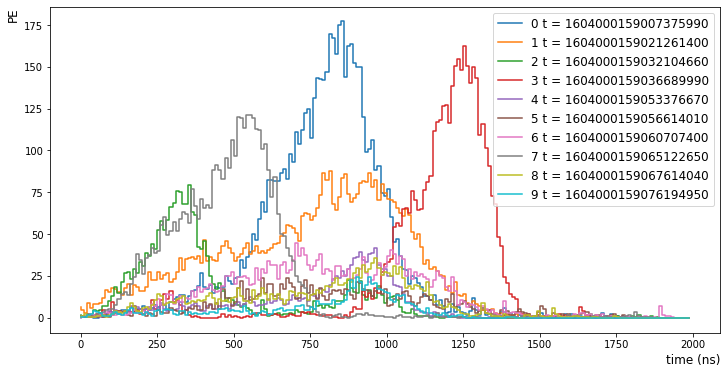

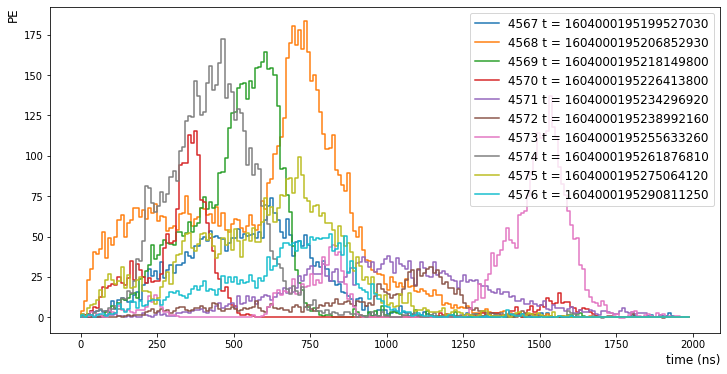

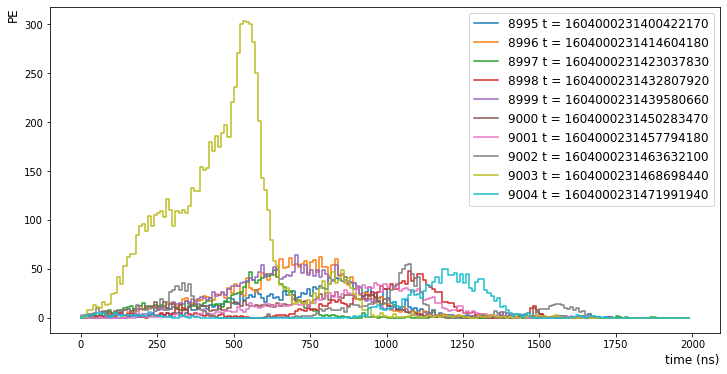

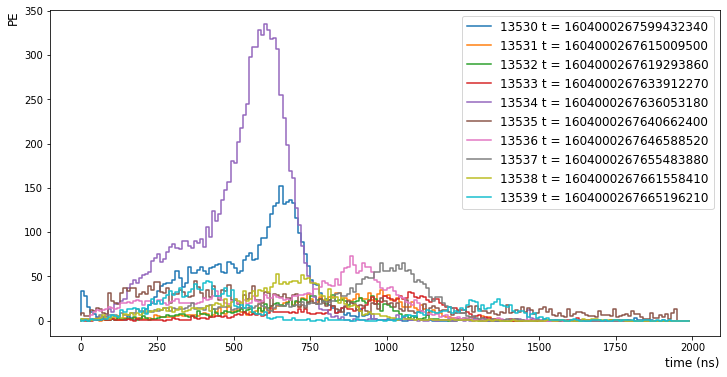

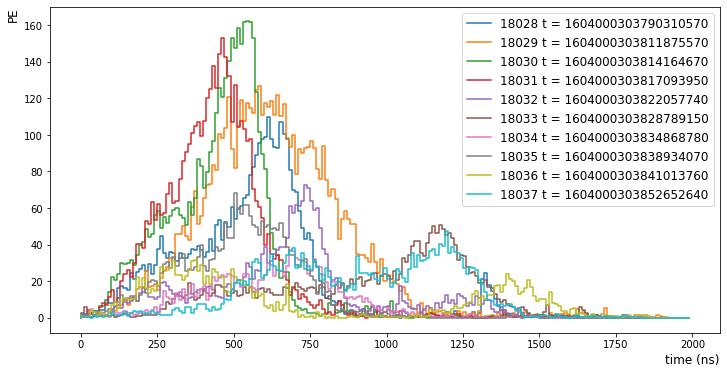

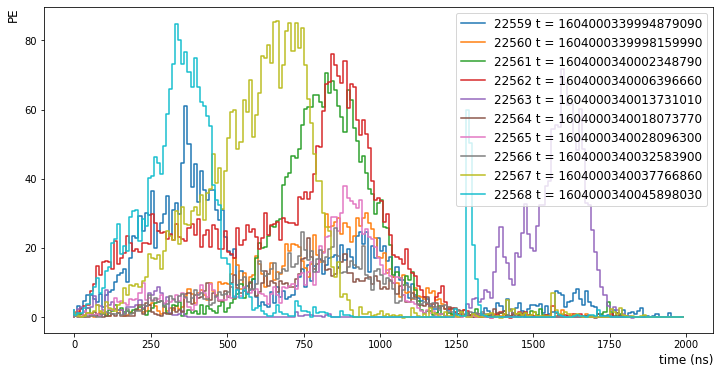

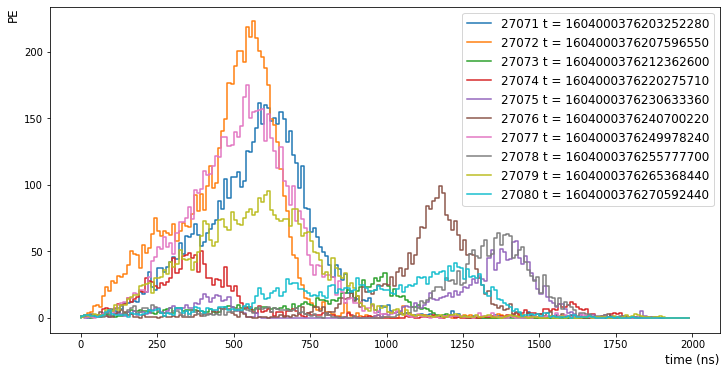

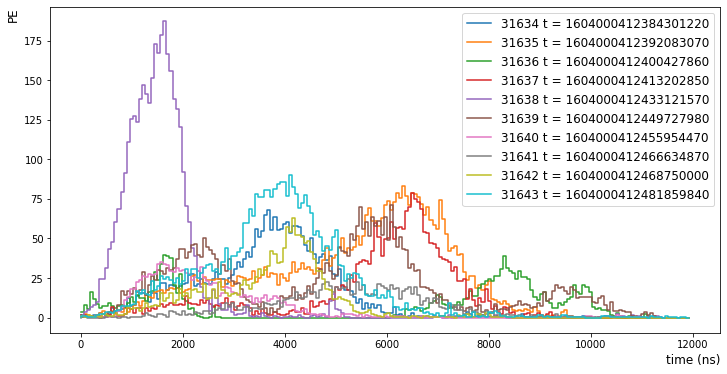

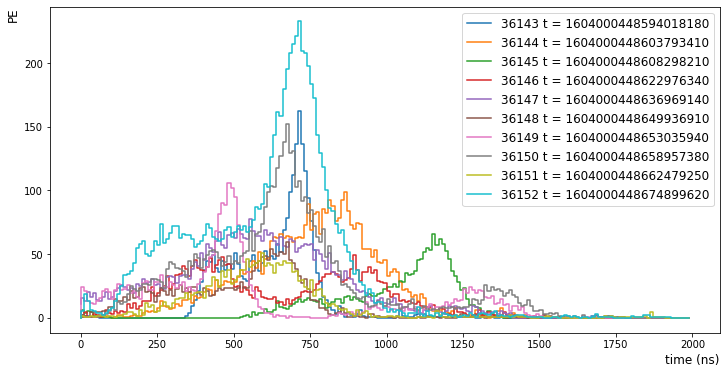

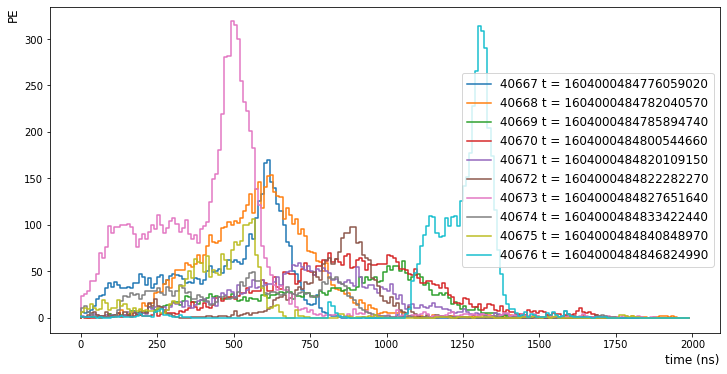

In [15]:
for div in range(ndiv):
    pdata, start2[div+1] = ssu.select_peaks_times(st, run_id2, peaks2, s2_times2, ndiv, div, int(start2[div]))

In [16]:
for div in range(ndiv):
    filename = f'data/select_peaks_run{run_id2}_div{div}.h5'
    pdata = pd.read_hdf(filename)
    rdata = ssu.select_records_times(st,run_id2,peaks2,s2_times2,s2_endtimes2,pdata,PMTs,ndiv,div,int(start2[div]))

run 009748 Total events 45207 total peaks 2135404 duration 361.97182402
division n. 0, tot. events 8158091, selected events: 65442 4567, time to process: 22.13 s


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['data'], dtype='object')]

  encoding=encoding,


run 009748 Total events 45207 total peaks 2135404 duration 361.97182402
division n. 1, tot. events 8366121, selected events: 65373 8995, time to process: 22.89 s
run 009748 Total events 45207 total peaks 2135404 duration 361.97182402
division n. 2, tot. events 8295849, selected events: 66008 13530, time to process: 22.69 s
run 009748 Total events 45207 total peaks 2135404 duration 361.97182402
division n. 3, tot. events 8301627, selected events: 66174 18028, time to process: 21.45 s
run 009748 Total events 45207 total peaks 2135404 duration 361.97182402
division n. 4, tot. events 8382500, selected events: 66551 22559, time to process: 23.02 s
run 009748 Total events 45207 total peaks 2135404 duration 361.97182402
division n. 5, tot. events 8225072, selected events: 65526 27071, time to process: 22.82 s
run 009748 Total events 45207 total peaks 2135404 duration 361.97182402
division n. 6, tot. events 8316478, selected events: 66269 31634, time to process: 22.45 s
run 009748 Total events

In [17]:
mdata = ssu.merge_records(run_id2, PMTs, ndiv = 10)

Reading: ./data/select_records_run009748_div0.h5, initial records: 65442, events: 4566
0, time to process: 0.35
1000, time to process: 19.74
2000, time to process: 38.89
3000, time to process: 58.06
4000, time to process: 77.39
Merged records 13678
Reading: ./data/select_records_run009748_div1.h5, initial records: 65373, events: 4427
4567, time to process: 89.07
5000, time to process: 97.37
6000, time to process: 116.62
7000, time to process: 135.54
8000, time to process: 155.27
Merged records 26956
Reading: ./data/select_records_run009748_div2.h5, initial records: 66008, events: 4534
8995, time to process: 176.14
9000, time to process: 176.22


/home/valerioda/xenon-notes/fast_response_analysis/s2_selection_utility.py:228: RuntimeWarning: invalid value encountered in double_scalars
  rec_x /= area_sum
/home/valerioda/xenon-notes/fast_response_analysis/s2_selection_utility.py:229: RuntimeWarning: invalid value encountered in double_scalars
  rec_y /= area_sum


10000, time to process: 196.00
11000, time to process: 216.97
12000, time to process: 237.93
13000, time to process: 259.04
Merged records 40541
Reading: ./data/select_records_run009748_div3.h5, initial records: 66174, events: 4497
13530, time to process: 271.15
14000, time to process: 281.39
15000, time to process: 301.93
16000, time to process: 323.45
17000, time to process: 344.93
18000, time to process: 365.39
Merged records 54018
Reading: ./data/select_records_run009748_div4.h5, initial records: 66551, events: 4530
18028, time to process: 366.64
19000, time to process: 385.02
20000, time to process: 404.61
21000, time to process: 423.75
22000, time to process: 443.09
Merged records 67601
Reading: ./data/select_records_run009748_div5.h5, initial records: 65526, events: 4511
22559, time to process: 454.23
23000, time to process: 462.66
24000, time to process: 481.52
25000, time to process: 500.58
26000, time to process: 519.95
27000, time to process: 539.54
Merged records 81124
Read

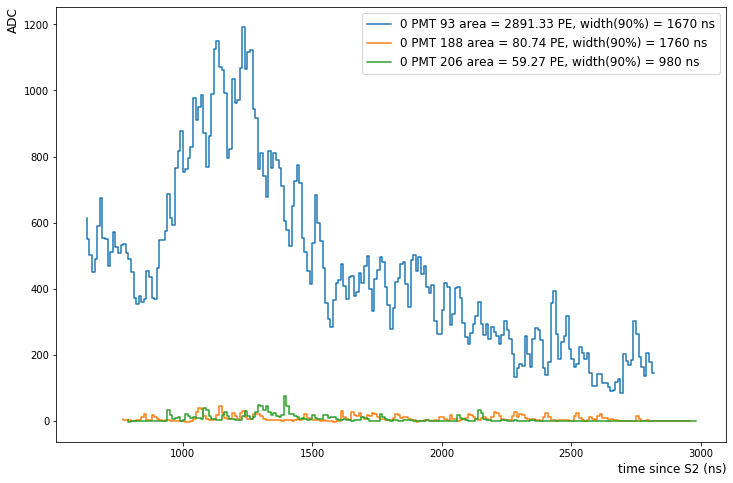

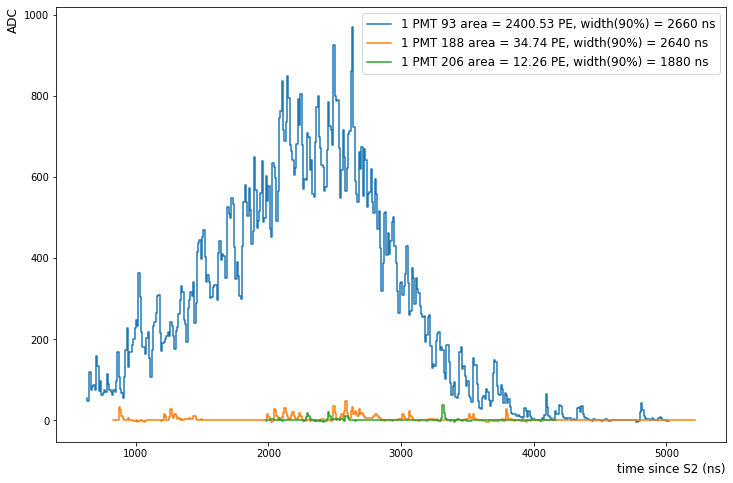

In [5]:
ssu.plot_records(run_id,PMTs,n=2)

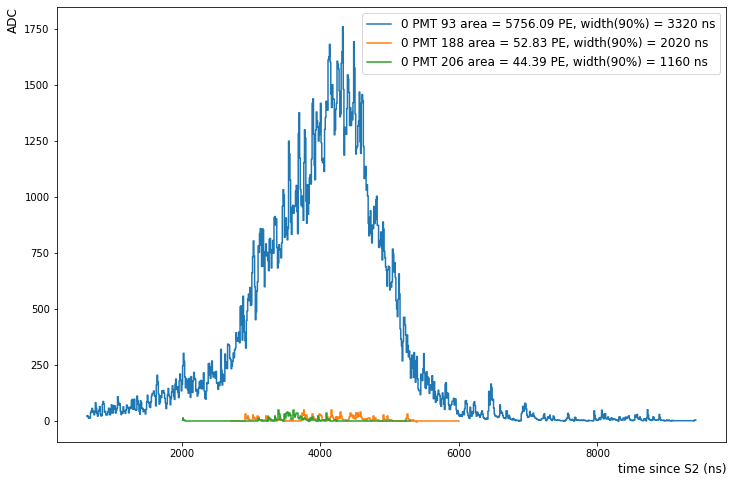

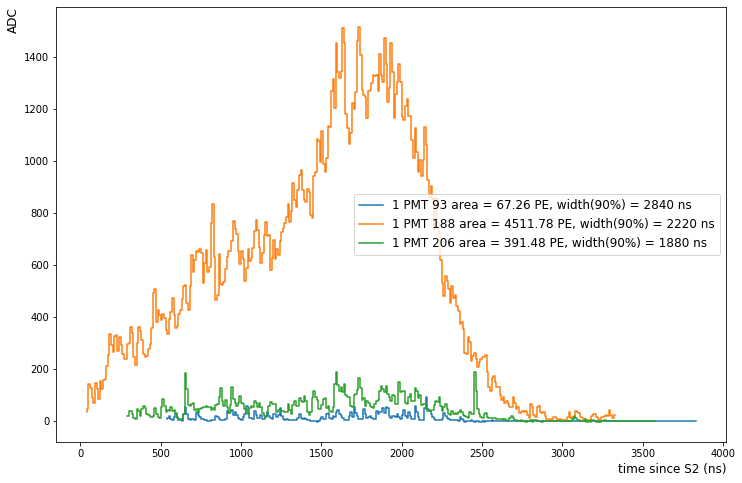

In [6]:
ssu.plot_records(run_id2,PMTs,n=2)

In [ ]:
plot_positions_area(run_id,PMTs)

PMT 93 events 45135
PMT 188 events 45094
PMT 206 events 45028


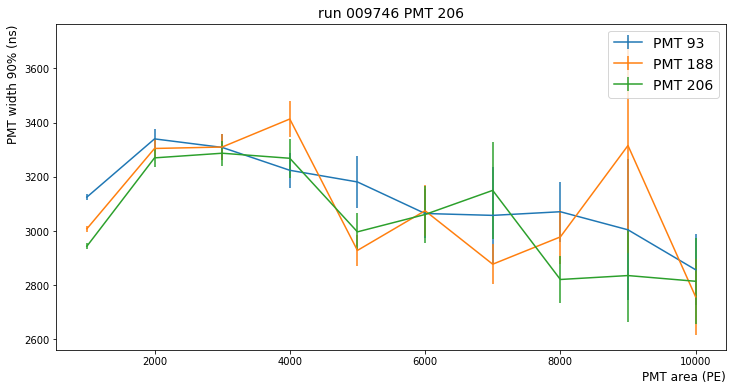

In [8]:
m, s = ssu.width_distribution_slice(run_id, PMTs)

PMT 93 events 45179
PMT 188 events 45167
PMT 206 events 45144


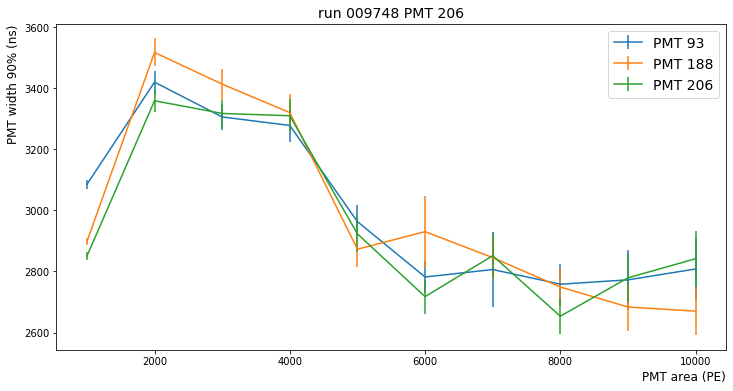

In [10]:
m, s = ssu.width_distribution_slice(run_id2, PMTs)

PMT n. 93 events 45135
PMT n. 188 events 45094
PMT n. 206 events 45028


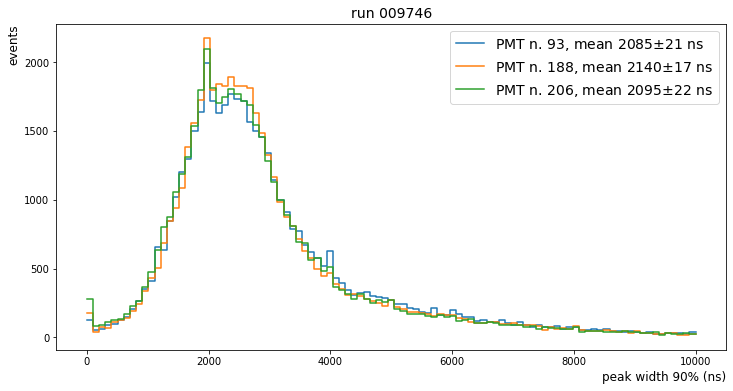

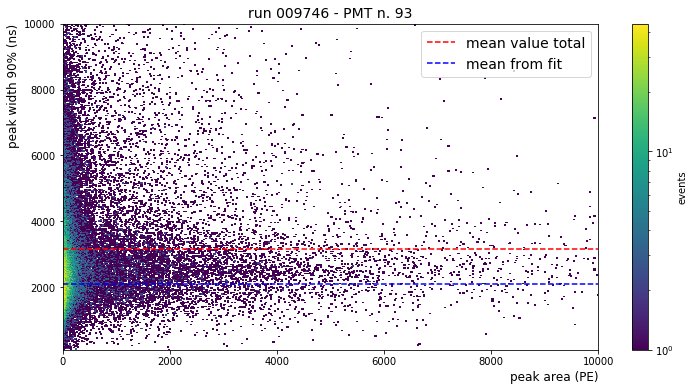

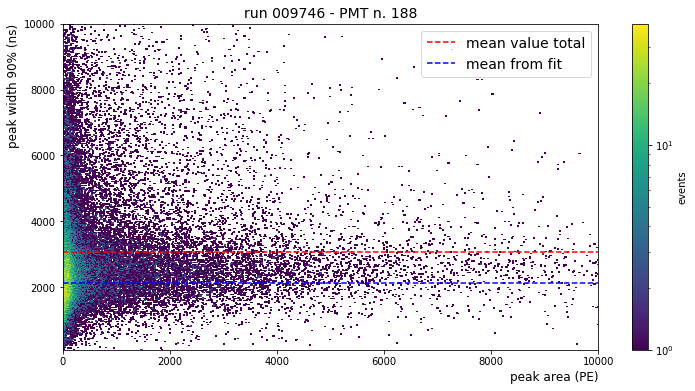

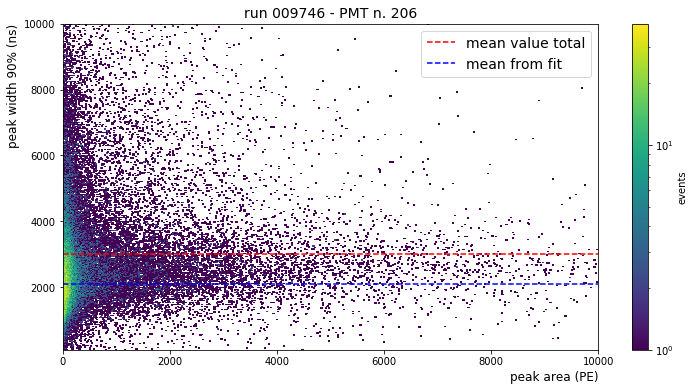

In [5]:
ssu.plot_area_width90_position(run_id, PMTs, 1e4, 1e4)

PMT n. 93 events 45179
PMT n. 188 events 45167
PMT n. 206 events 45144


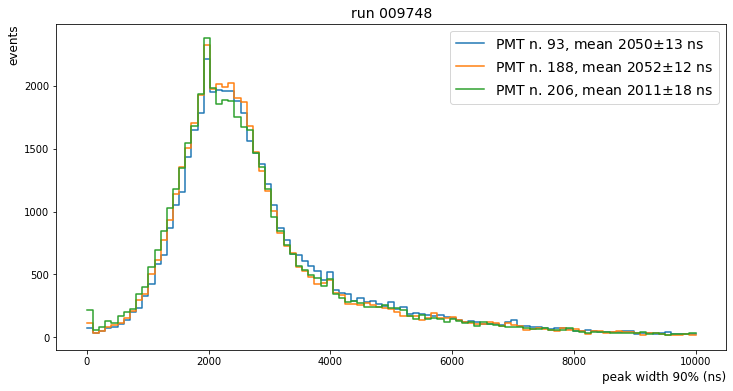

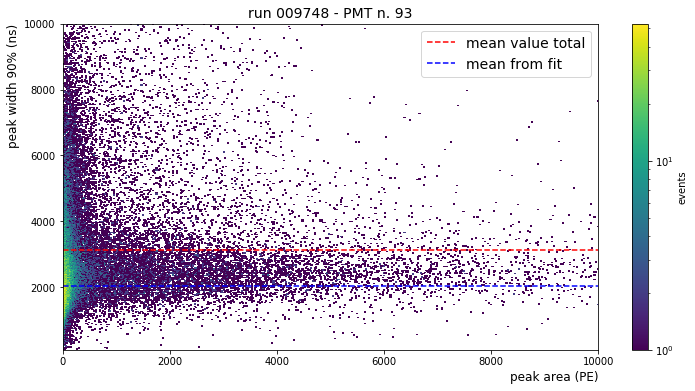

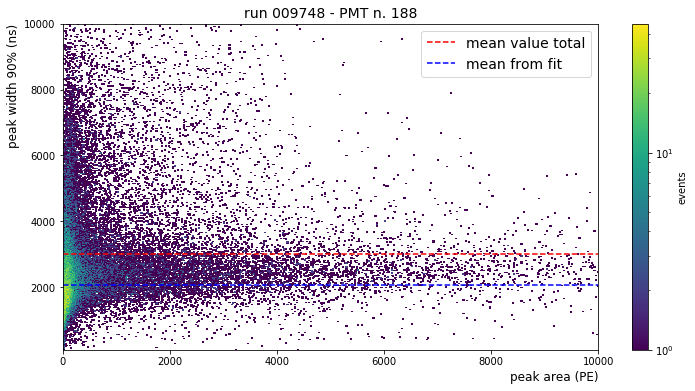

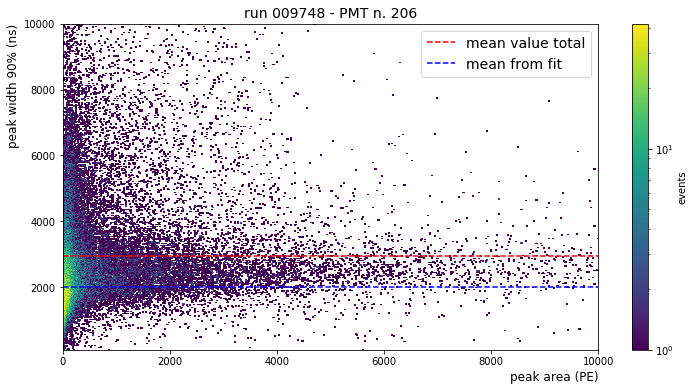

In [6]:
ssu.plot_area_width90_position(run_id2, PMTs, 1e4, 1e4)

PMT n. 93 events 9240
PMT n. 188 events 10275
PMT n. 206 events 9760


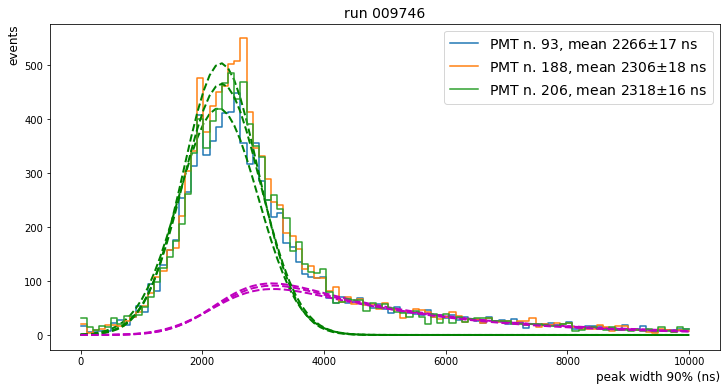

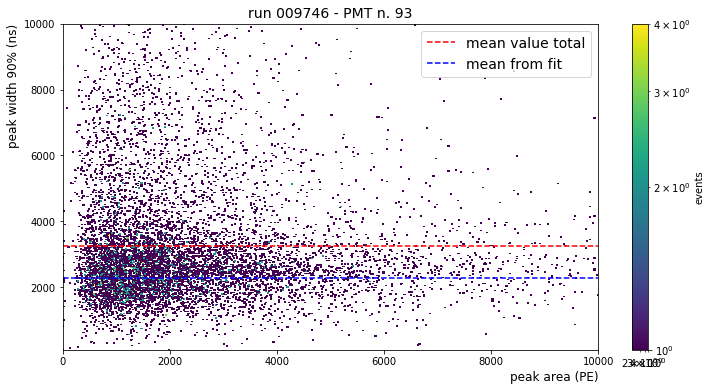

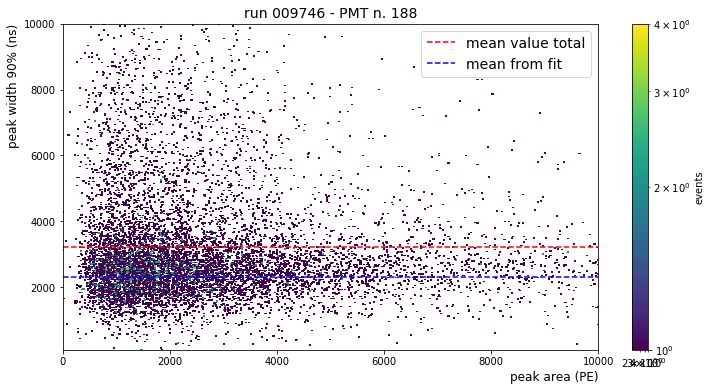

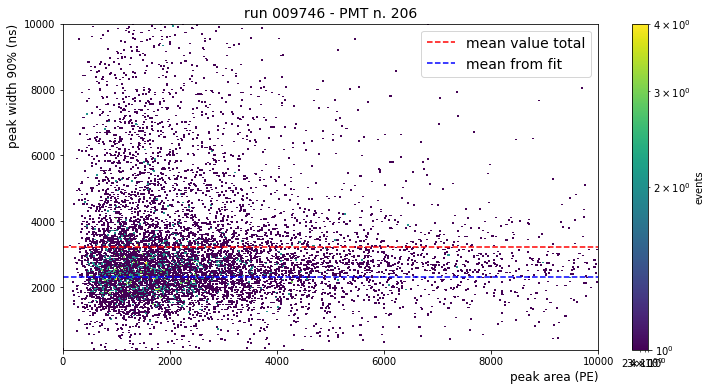

In [5]:
ssu.plot_area_width90_position(run_id, PMTs, 1e4, 1e4, position = 1, distance=8,plot=1)

PMT n. 93 events 10773
PMT n. 188 events 10169
PMT n. 206 events 9496


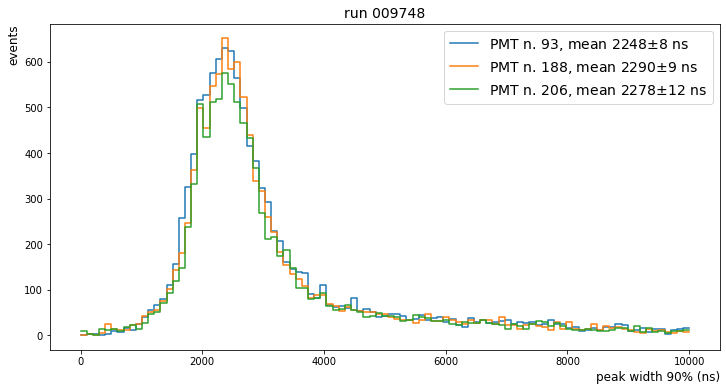

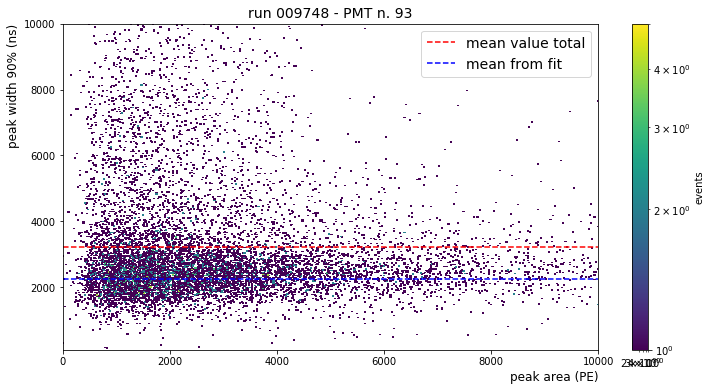

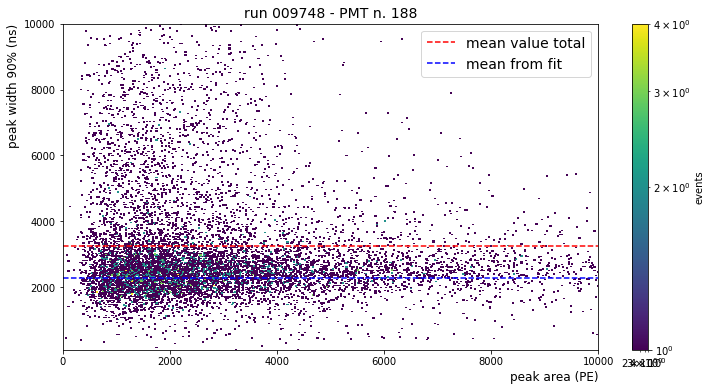

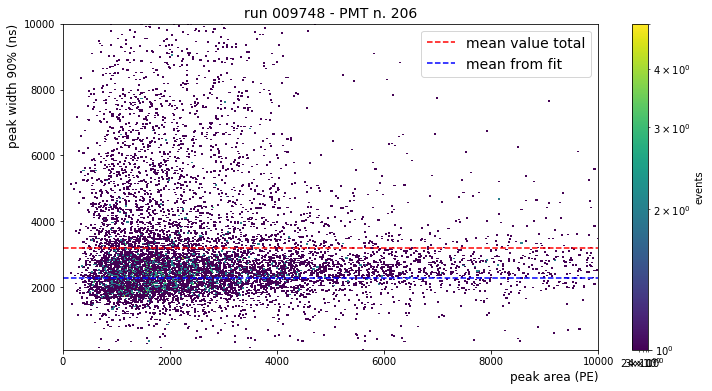

In [13]:
ssu.plot_area_width90_position(run_id2, PMTs, 1e4, 1e4, position = 1, distance=8)

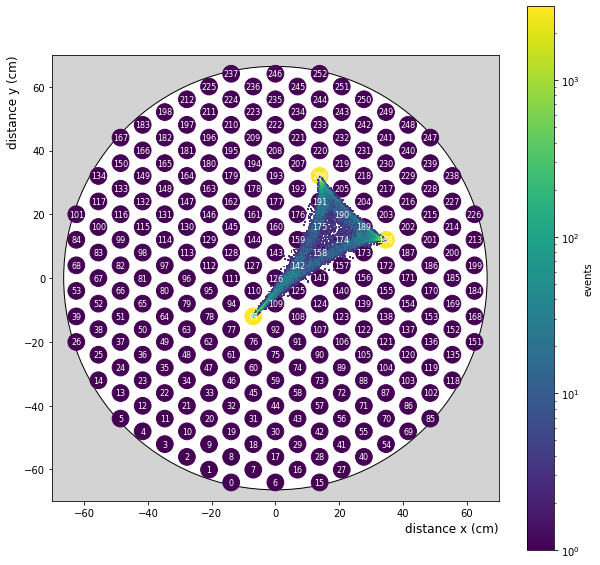

In [5]:
ssu.plot_positions(run_id, PMTs)